# Diseño Muestral Complejo y Calibración (Raking)
**Autor:** Juan Carlos Chávez  
**Objetivo:** Simular un diseño muestral bi-etápico (Estratificado y por Conglomerados) y aplicar técnicas de calibración (Raking) para corregir el sesgo de no-respuesta.

**Caso de Uso:** Encuesta de Mercado para estimación de ingreso promedio nacional.

In [ ]:
# ========================================
# FUNCIÓN DE RAKING (IMPLEMENTACIÓN MANUAL)
# ========================================

def raking_calibration(sample_df, base_weights, calibration_vars, population_totals, 
                       max_iter=50, tol=1e-6, verbose=True):
    """
    Implementación manual de raking (Iterative Proportional Fitting)
    
    Parameters:
    -----------
    sample_df : DataFrame con las variables de calibración
    base_weights : array de pesos base
    calibration_vars : list de nombres de columnas para calibrar
    population_totals : dict con {variable: {categoria: total}}
    max_iter : número máximo de iteraciones
    tol : tolerancia para convergencia
    verbose : si True, imprime información de convergencia
    
    Returns:
    --------
    weights : array con los pesos calibrados
    """
    weights = base_weights.copy()
    
    if verbose:
        print("Iniciando calibración por Raking...")
        print(f"Pesos iniciales - suma: {weights.sum():.2f}")
    
    for iteration in range(max_iter):
        weights_old = weights.copy()
        
        # Iterar sobre cada variable de calibración
        for var in calibration_vars:
            # Obtener categorías únicas
            categories = sample_df[var].unique()
            
            for cat in categories:
                # Máscara para esta categoría
                mask = sample_df[var] == cat
                
                # Total ponderado actual en la muestra
                sample_total = np.sum(weights[mask])
                
                # Total poblacional conocido
                pop_total = population_totals[var][cat]
                
                # Factor de ajuste
                if sample_total > 0:
                    adjustment_factor = pop_total / sample_total
                    weights[mask] *= adjustment_factor
        
        # Verificar convergencia
        max_change = np.max(np.abs(weights - weights_old))
        
        if verbose and (iteration % 10 == 0 or iteration < 5):
            print(f"  Iteración {iteration + 1}: Max cambio = {max_change:.6f}")
        
        if max_change < tol:
            if verbose:
                print(f"\nConvergencia alcanzada en {iteration + 1} iteraciones")
                print(f"  Suma final de pesos: {weights.sum():.2f}")
            break
    else:
        if verbose:
            print(f"\nMáximo de iteraciones alcanzado ({max_iter})")
    
    return weights


def verify_calibration(sample_df, weights, calibration_vars, population_totals):
    """
    Verifica qué tan bien se calibraron los pesos comparando totales
    """
    print("VERIFICACIÓN DE CALIBRACIÓN")
    
    for var in calibration_vars:
        print(f"\n{var.upper()}:")
        print(f"{'Categoría':<15} {'Muestra Ponderada':<20} {'Población Real':<20} {'Diferencia':<15}")
        
        for cat in sorted(sample_df[var].unique()):
            mask = sample_df[var] == cat
            sample_total = np.sum(weights[mask])
            pop_total = population_totals[var][cat]
            diff = sample_total - pop_total
            
            print(f"{cat:<15} {sample_total:>19,.0f} {pop_total:>19,.0f} {diff:>14,.0f}")

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar Censo (Nuestra "Verdad Absoluta")
census = pd.read_csv('../data/population_census.csv')

print(f"Población Total: {len(census)}")
print(f"Ingreso Real Promedio (Target): ${census['income'].mean():.2f}")

# Calcular Totales Conocidos (Marginales) para la Calibración posterior
# Imaginemos que el INEGI nos da estos datos exactos:
known_totals_age = census.groupby('age_group')['id'].count().to_dict()
known_totals_gender = census.groupby('gender')['id'].count().to_dict()

print("\nTotales Censales (Control):")
print(known_totals_age)
print(known_totals_gender)

Población Total: 100000
Ingreso Real Promedio (Target): $21994.90

Totales Censales (Control):
{'18-29': 29958, '30-49': 39843, '50+': 30199}
{'F': 51932, 'M': 48068}


In [3]:
# --- PASO 1: Diseño Muestral ---
# Estrategia: Estratificado por 'region', Cluster por 'municipio'

# Calcular información del censo por región
census_info = census.groupby('region').agg({
    'municipio': 'nunique',  # N_municipios por región
    'id': 'count'  # N_personas por región
}).rename(columns={'municipio': 'N_municipios', 'id': 'N_personas'})

print("\nInformación del Censo por Región:")
print(census_info)

# Etapa 1: Seleccionar 5 municipios (Clusters) aleatorios por Región (Estrato)
n_municipios_seleccionados = 5

selected_clusters = census.groupby('region')['municipio'].unique().apply(
    lambda x: np.random.choice(x, size=n_municipios_seleccionados, replace=False)
).explode().values

sample_stage1 = census[census['municipio'].isin(selected_clusters)].copy()

print(f"\nMunicipios seleccionados: {len(selected_clusters)}")

# Etapa 2: Muestreo Aleatorio Simple (SRS) dentro de los municipios seleccionados
n_personas_por_municipio = 100

sample = sample_stage1.groupby('municipio').sample(n=n_personas_por_municipio, random_state=42).copy()

print(f"Personas seleccionadas por municipio: {n_personas_por_municipio}")
print(f"Tamaño de la Muestra Inicial: {len(sample):,}")

# --- CÁLCULO DE PESOS DE DISEÑO ---
# Para cada persona, calculamos:
# 1. Prob(municipio seleccionado | región)
# 2. Prob(persona seleccionada | municipio)
# 3. Prob(total) = Prob(municipio) × Prob(persona)
# 4. Peso = 1 / Prob(total)

# Agregar información necesaria para calcular probabilidades
# Información por municipio en el censo
municipio_info = census.groupby(['region', 'municipio']).size().reset_index(name='N_personas_municipio')

# Merge con la muestra
sample = sample.merge(municipio_info, on=['region', 'municipio'], how='left')
sample = sample.merge(census_info, on='region', how='left')

# Cálculo de probabilidades por etapa
# Prob_1: Probabilidad de que el municipio sea seleccionado en su región
sample['prob_municipio'] = n_municipios_seleccionados / sample['N_municipios']

# Prob_2: Probabilidad de que la persona sea seleccionada dentro del municipio
sample['prob_persona'] = n_personas_por_municipio / sample['N_personas_municipio']

# Probabilidad total
sample['prob_total'] = sample['prob_municipio'] * sample['prob_persona']

# Peso de diseño = inverso de la probabilidad
sample['base_weight'] = 1 / sample['prob_total']


Información del Censo por Región:
        N_municipios  N_personas
region                          
Norte              8       39985
Sur               12       60015

Municipios seleccionados: 10
Personas seleccionadas por municipio: 100
Tamaño de la Muestra Inicial: 1,000


In [4]:
# Mostrar estadísticas de los pesos
print("ESTADÍSTICAS DE PESOS DE DISEÑO")
print(f"{'Métrica':<25} {'Valor':<20}")
print("-" * 45)
print(f"{'Peso mínimo':<25} {sample['base_weight'].min():>19.2f}")
print(f"{'Peso máximo':<25} {sample['base_weight'].max():>19.2f}")
print(f"{'Peso promedio':<25} {sample['base_weight'].mean():>19.2f}")
print(f"{'Desv. estándar':<25} {sample['base_weight'].std():>19.2f}")
print(f"{'Suma de pesos':<25} {sample['base_weight'].sum():>19,.0f}")
print(f"{'Población total':<25} {len(census):>19,}")
print(f"{'Diferencia':<25} {(sample['base_weight'].sum() - len(census)):>19,.0f}")

# Verificar que la suma de pesos aproxima la población
print(f"\n✓ Proporción cubierta: {100 * sample['base_weight'].sum() / len(census):.2f}%")

# Mostrar ejemplo de cálculo para algunas observaciones
print("EJEMPLO DE CÁLCULO DE PESOS (primeras 3 observaciones)")
ejemplo = sample[['region', 'municipio', 'N_municipios', 'N_personas_municipio', 
                   'prob_municipio', 'prob_persona', 'prob_total', 'base_weight']].head(3)
print(ejemplo.to_string(index=False))

ESTADÍSTICAS DE PESOS DE DISEÑO
Métrica                   Valor               
---------------------------------------------
Peso mínimo                             78.43
Peso máximo                            121.97
Peso promedio                          100.25
Desv. estándar                          20.42
Suma de pesos                         100,252
Población total                       100,000
Diferencia                                252

✓ Proporción cubierta: 100.25%
EJEMPLO DE CÁLCULO DE PESOS (primeras 3 observaciones)
region  municipio  N_municipios  N_personas_municipio  prob_municipio  prob_persona  prob_total  base_weight
 Norte          1             8                  5001           0.625      0.019996    0.012498       80.016
 Norte          1             8                  5001           0.625      0.019996    0.012498       80.016
 Norte          1             8                  5001           0.625      0.019996    0.012498       80.016


In [5]:
# --- PASO 2: Introducir Sesgo (No-Respuesta) ---
# Simulamos que los HOMBRES JÓVENES (18-29) no contestan la encuesta (común en campo)

# Probabilidad de respuesta
def response_prob(row):
    if row['gender'] == 'M' and row['age_group'] == '18-29':
        return 0.3 # Solo responde el 30%
    return 0.9

np.random.seed(99)
sample['responded'] = sample.apply(lambda x: np.random.rand() < response_prob(x), axis=1)

# Nos quedamos solo con los que respondieron (Muestra Final Efectiva)
final_sample = sample[sample['responded'] == True].copy()

print(f"Muestra Efectiva: {len(final_sample)}")
print(f"Promedio Ingreso (Sesgado): ${final_sample['income'].mean():.2f}")
print(f"Error vs Realidad: ${(final_sample['income'].mean() - census['income'].mean()):.2f}")
# Notaremos que el ingreso está distorsionado porque faltan jóvenes (que ganan menos)

Muestra Efectiva: 803
Promedio Ingreso (Sesgado): $22970.72
Error vs Realidad: $975.82


In [6]:
# --- PASO 3: Calibración (Raking) ---
# Ajustamos los pesos para que la muestra cuadre con los totales de Edad y Género del censo

# Preparar los totales poblacionales
population_totals = {
    'age_group': known_totals_age,
    'gender': known_totals_gender
}

# Aplicar raking manual
final_sample['calibrated_weight'] = raking_calibration(
    final_sample,
    final_sample['base_weight'].values,
    ['age_group', 'gender'],
    population_totals,
    max_iter=50,
    tol=1e-6,
    verbose=True
)

# Verificar la calibración
verify_calibration(
    final_sample, 
    final_sample['calibrated_weight'].values,
    ['age_group', 'gender'],
    population_totals
)

print("¡Calibración completada!")

Iniciando calibración por Raking...
Pesos iniciales - suma: 80520.49
  Iteración 1: Max cambio = 90.780758
  Iteración 2: Max cambio = 11.944957
  Iteración 3: Max cambio = 0.662872
  Iteración 4: Max cambio = 0.036579
  Iteración 5: Max cambio = 0.002018

Convergencia alcanzada en 8 iteraciones
  Suma final de pesos: 100000.00
VERIFICACIÓN DE CALIBRACIÓN

AGE_GROUP:
Categoría       Muestra Ponderada    Población Real       Diferencia     
18-29                        29,958              29,958             -0
30-49                        39,843              39,843              0
50+                          30,199              30,199              0

GENDER:
Categoría       Muestra Ponderada    Población Real       Diferencia     
F                            51,932              51,932             -0
M                            48,068              48,068              0
¡Calibración completada!




               Metodología  Ingreso Promedio Estimado  Diferencia vs Real  Error Relativo (%)
              Censo (Real)               21994.901718            0.000000            0.000000
    Muestra (Sin Ponderar)               22970.720174          975.818457            4.436567
Muestra (Calibrada/Raking)               22147.079926          152.178208            0.691879


ESTADÍSTICAS DE PESOS:
Métrica              Base            Calibrado      
--------------------------------------------------
Mínimo                        78.43          75.33
Máximo                       121.97         225.40
Media                        100.27         124.53
Desv. Estándar                20.43          34.83
Suma Total                   80,520        100,000


/tmp/ipykernel_2771/1173810313.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Metodología', y='Ingreso Promedio Estimado', data=results,


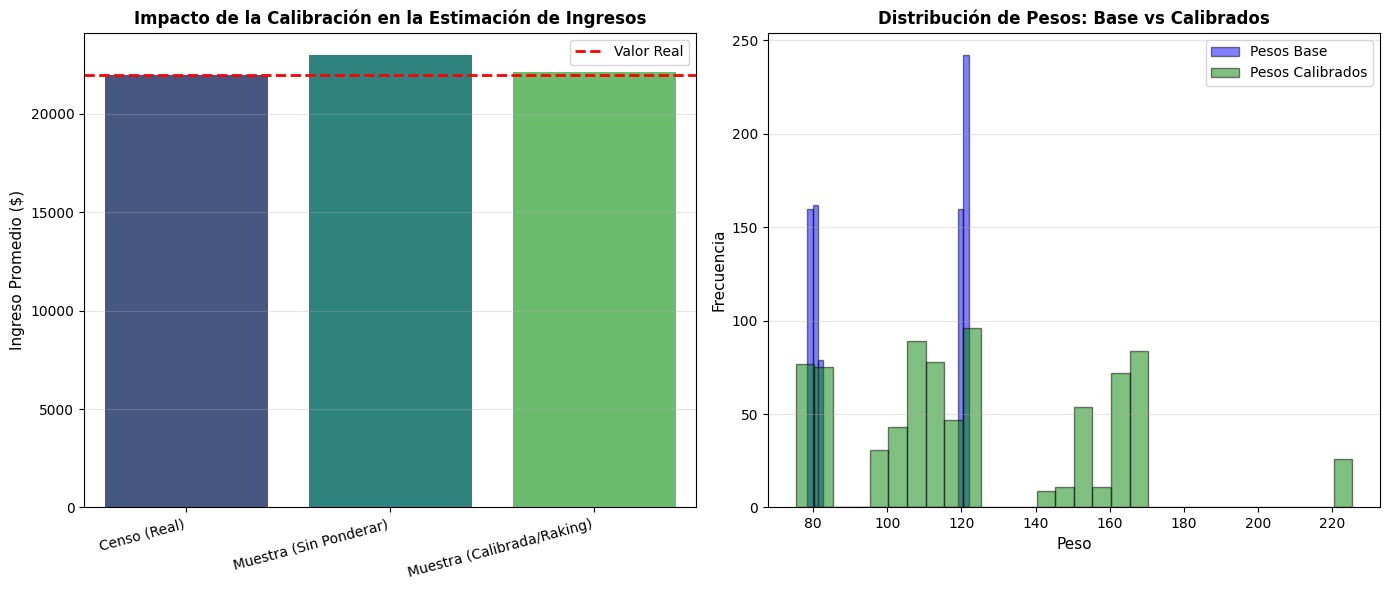

In [7]:
# --- PASO 4: Evaluación de Resultados ---

def weighted_mean(df, val_col, weight_col):
    return np.average(df[val_col], weights=df[weight_col])

real_mean = census['income'].mean()
biased_mean = final_sample['income'].mean()
weighted_mean_val = weighted_mean(final_sample, 'income', 'calibrated_weight')

results = pd.DataFrame({
    'Metodología': ['Censo (Real)', 'Muestra (Sin Ponderar)', 'Muestra (Calibrada/Raking)'],
    'Ingreso Promedio Estimado': [real_mean, biased_mean, weighted_mean_val],
    'Diferencia vs Real': [0, biased_mean - real_mean, weighted_mean_val - real_mean],
    'Error Relativo (%)': [0, 
                          100 * (biased_mean - real_mean) / real_mean,
                          100 * (weighted_mean_val - real_mean) / real_mean]
})

print("\n")
print(results.to_string(index=False))

# Análisis adicional: distribución de pesos
print(f"\n\nESTADÍSTICAS DE PESOS:")
print(f"{'Métrica':<20} {'Base':<15} {'Calibrado':<15}")
print("-" * 50)
print(f"{'Mínimo':<20} {final_sample['base_weight'].min():>14.2f} {final_sample['calibrated_weight'].min():>14.2f}")
print(f"{'Máximo':<20} {final_sample['base_weight'].max():>14.2f} {final_sample['calibrated_weight'].max():>14.2f}")
print(f"{'Media':<20} {final_sample['base_weight'].mean():>14.2f} {final_sample['calibrated_weight'].mean():>14.2f}")
print(f"{'Desv. Estándar':<20} {final_sample['base_weight'].std():>14.2f} {final_sample['calibrated_weight'].std():>14.2f}")
print(f"{'Suma Total':<20} {final_sample['base_weight'].sum():>14,.0f} {final_sample['calibrated_weight'].sum():>14,.0f}")

# --- Visualización ---
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Gráfico 1: Comparación de estimaciones
ax1 = axes[0]
sns.barplot(x='Metodología', y='Ingreso Promedio Estimado', data=results, 
            palette='viridis', ax=ax1)
ax1.axhline(y=real_mean, color='r', linestyle='--', linewidth=2, label='Valor Real')
ax1.set_title('Impacto de la Calibración en la Estimación de Ingresos', 
              fontsize=12, fontweight='bold')
ax1.set_ylabel('Ingreso Promedio ($)', fontsize=11)
ax1.set_xlabel('')
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# Rotar etiquetas
for label in ax1.get_xticklabels():
    label.set_rotation(15)
    label.set_ha('right')

# Gráfico 2: Distribución de pesos
ax2 = axes[1]
ax2.hist(final_sample['base_weight'], bins=30, alpha=0.5, 
         label='Pesos Base', color='blue', edgecolor='black')
ax2.hist(final_sample['calibrated_weight'], bins=30, alpha=0.5, 
         label='Pesos Calibrados', color='green', edgecolor='black')
ax2.set_title('Distribución de Pesos: Base vs Calibrados', 
              fontsize=12, fontweight='bold')
ax2.set_xlabel('Peso', fontsize=11)
ax2.set_ylabel('Frecuencia', fontsize=11)
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()